# Example: Face Recognition
As an example of support vector machines in action, let's take a look at the facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn:

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


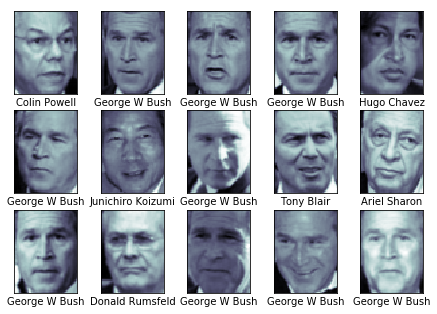

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 5)
fig.subplots_adjust(left=0.0325, right=1, bottom=-0.1, wspace=0.2)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
           xlabel=faces.target_names[faces.target[i]])

Each image contains 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of prepeocessor to extract more meaningful features; here we will use PCA to extract 150 fundmental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [22]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Now we will split into training and testing data

In [23]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters. Here we will adjust `c` (which controls the margin hardness) and `gamma` (which controls the size of the radia basis function kernel), and determine the best model:

In [24]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 18.7 s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.<br><br>
Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [25]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:


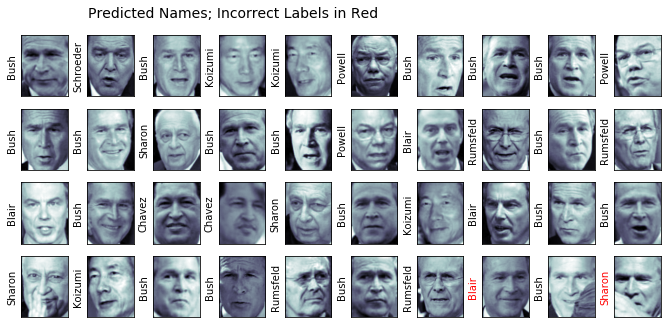

In [45]:
fig, ax = plt.subplots(4, 10)
fig.subplots_adjust(left=0, right=1.5, bottom=-0.1, wspace=0.2)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [46]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.87      0.72        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.72      0.84      0.78        31
    George W Bush       0.98      0.81      0.89       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.80      1.00      0.89        12
       Tony Blair       0.83      0.95      0.89        42

      avg / total       0.86      0.85      0.85       337



We might also create confusion matrix.

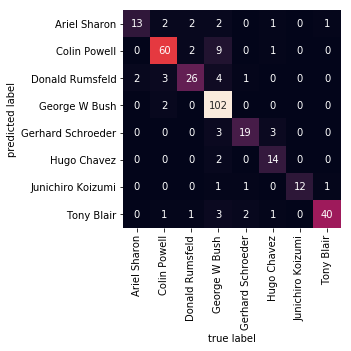

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');